### MLE vs. MAPE

- As in [Linear regression using OLS](https://github.com/AlaaSedeeq/Pattern-recognition-and-machine-learning/blob/main/Ch%2003%20Linear%20Models%20For%20Regression/01%20Linear%20regression%20using%20OLS.ipynb) notebook, the closed-form solution for maximum likelihood is:
$$W_{ML} = (\Phi^T\Phi)^{-1}\Phi^T \;\;(Normal Equations)$$<br>

- For the **Maximum a posterior (MAP)**, we are not maximizing the likelihood, but we introduce a prior over the parameters $W$, then maximize the posterior (product of likelihood and prior).
- Also, like MLE, we can still have a closed-form solution for $W$.
- Assume:
    - $t = W^TX + \epsilon \;,\; \epsilon$ ~ $N(0, \sigma^2)$
    - The prior knowledge is $P(W) = N(W|\alpha)$
    - And then the posterior is $P(W|t, X, \beta, \alpha) \propto N(t| W, X,\beta) P(W|\alpha)$
- Then we have, $W_{MAP} = argmax_{W}P(W|t, X, \beta, \alpha)$
- So the closed-form of MAP is:
$$W_{MAP}=(\Phi^T\Phi + \lambda I)^{-1}\Phi^T$$

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

#### Generate the data

In [2]:
def simulator(f, sample_size, std, l=0, h=1):
    x = np.linspace(l, h, sample_size)
    noise = np.random.normal(scale=std, size=x.shape)
    t = f(x) + noise
    return x.reshape(sample_size, -1), t

def f(x):
    return np.sin(2 * np.pi * x)

# generate data
def genrate_data(N_tr=10, N_ts=100, std=0.3, l=0, h=1):
    x_train, y_train = simulator(f, N_tr, std, l=l, h=h)
    x_test = np.linspace(l, h, N_ts)
    y_test = f(x_test)
    return x_train.reshape(N_tr, -1), y_train, x_test.reshape(N_ts, -1), y_test

#### Apply MLE and MAP closed-form solution

In [3]:
class MLE_MAP:
    def __init__(self, mle_mape='MLE', lamba=0.9):
        self.mle_mape = mle_mape.lower()
        self.lamba = lamba
    
    def _scale_fit(self, X, L=-1, H=1):
        P = X.shape[1]
        self.a = []; self.b = []
        for p in range(P):
            self.a.append(((H * min(X[:, p])) - (L * max(X[:, p])))/(H-L))
            self.b.append((max(X[:, p]) - min(X[:, p]))/(H - L))

    def _scale_transform(self, X):
        X_scaled = (X - self.a)/self.b
        return X_scaled.reshape(X.shape[0], -1)
    
    def _scale_inverse(X):
        return (X * self.b) + selfa
    
    def fit(self, X, y, scale=True):
        self.scale = scale
        self.N, self.P = X.shape
        # add cloumn of ones in X for the bias term
        if self.scale:
            self._scale_fit(X)
            X = self._scale_transform(X)
        X = np.append(X, np.ones((self.N, 1)), axis=1)   
        y = y.reshape(self.N, 1)
        if self.mle_mape=='mle':
            # The Normal Equation W(ML) = (X^T X)^-1 X^T Y
            self.W = np.linalg.inv(X.T @ X) @ X.T @ y
            self.B_inv = np.mean(np.square(X @ self.W - y))

        elif self.mle_mape=='map':
            # The Normal Equation W(ML) = (X^T X + lambda I)^-1 X^T Y
            self.W = np.linalg.inv(self.lamba * np.eye(self.P + 1) + np.dot(X.T, X)) @ X.T @ y
            self.B_inv = np.mean(np.square(X @ self.W - y))
            
        else:
            raise('Only MLE and MAP')

    def predict(self, X, std=False):
        
        if self.scale:
            X = self._scale_transform(X)
        
        X = X.reshape(-1, self.P)
        X = np.append(X, np.ones((X.shape[0],1)), axis=1)
        preds = np.dot(X, self.W)
        if std:
            std_ = np.sqrt(self.B_inv) + np.zeros_like(preds)
            return preds, std_
        return preds

#### Plot the results

In [79]:
def plot_results(X_tr, y_tr, X_ts, y_ts, pred, ax, std=0, title=None, pred_label='', true_f='', text=None):
    ax.scatter(X_tr, y_tr, facecolor="none", edgecolor="b", s=50, label="training data")
    ax.plot(X_ts, pred, 'r', label=pred_label)
    ax.plot(X_ts, y_ts, c="g", label=true_f)
    ax.fill_between(x=X_ts.reshape(-1), y1=(pred-std).reshape(-1), y2=(pred+std).reshape(-1),
                    color='orange', alpha=0.5, label='std')
    
    if title:
        ax.set_title(title, fontsize=16)
    if text:
        ax.set_ylim(-1.6, 2)
        ax.text(0, 1.7, text, size=20)
    ax.set_xlabel('$X$', size=15)
    ax.set_ylabel('$Y$', rotation=0, size=15)
    ax.legend()
    return ax

# generate polynomial basis
def PolynomialFeature(X, degrees):
    
    X_poly = X.copy()
    
    for i in range(2, degrees+2):
        X_poly = np.append(X_poly, X**i, axis=1)
    
    return X_poly

#### Gather the data and apply ploynomial basis function (degree = 8)

In [71]:
d = 8
X_train, y_train, X_test, y_test = genrate_data(N_tr=15, l=0, h=1)
Poly_X = PolynomialFeature(X_train, d)
Poly_X_test = PolynomialFeature(X_test, d)

In [72]:
# MLE
model_mle = MLE_MAP(mle_mape='MLE')
model_mle.fit(Poly_X, y_train)
preds_mle, std_mle = model_mle.predict(Poly_X_test, std=True)

# MAP
model_map = MLE_MAP(mle_mape='MAP', lamba=1e-2)
model_map.fit(Poly_X, y_train)
preds_map, std_map = model_map.predict(Poly_X_test, std=True)

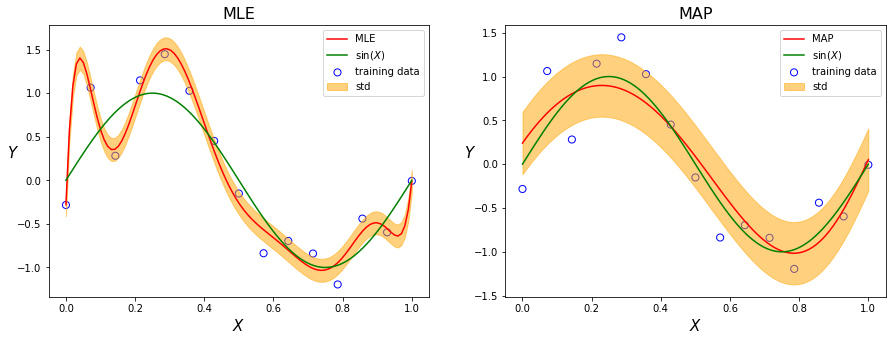

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=preds_mle,
             ax=axes[0], pred_label='MLE', true_f='$\sin(X)$', std=std_mle, title='MLE')

plot_results(X_tr=X_train, y_tr=y_train, X_ts=X_test, y_ts=y_test, pred=preds_map,
             ax=axes[1], pred_label='MAP', true_f='$\sin(X)$', std=std_map, title='MAP');

> ### MLE is prone to overfitting, whereas the MAP controls overfitting by the regularisation term.

In [140]:
d = 10
X_train, y_train, X_test, y_test = genrate_data(N_tr=100, l=0, h=1)
Poly_X = PolynomialFeature(X_train, d)
Poly_X_test = PolynomialFeature(X_test, d)
results = {}

for p in np.linspace(-10, 3, 30):
    # MAP
    model = MLE_MAP(mle_mape='MAP', lamba=np.power(10, p))
    model.fit(Poly_X, y_train)
    preds_tr = model.predict(Poly_X)
    preds_ts = model.predict(Poly_X_test)
    results[p] = [mean_squared_error(preds_tr, y_train), mean_squared_error(preds_ts, y_test)]

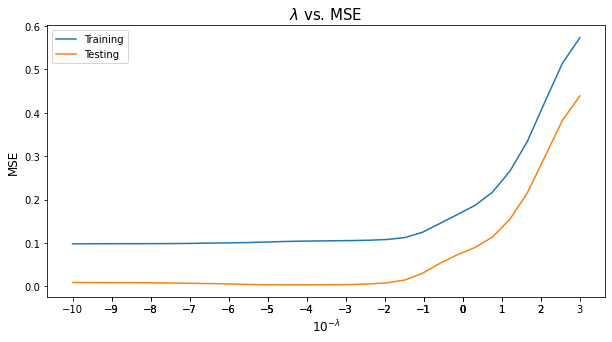

In [158]:
ax = pd.DataFrame(results).T.rename(columns={0:'Training', 1:'Testing'}).plot(figsize=(10, 5))
ax.set_xticks(list(map(int, np.linspace(-10, 3, 30))))
ax.set_title('$\lambda$ vs. MSE', fontsize=15)
ax.set_xlabel('$10^{-\lambda}$', fontsize=12)
ax.set_ylabel('MSE', fontsize=12);